# Feature engineering
## Brief
选择kaggle上一个经典的[泰坦尼克号之灾问题](https://www.kaggle.com/c/titanic)作为数据源，做一些特征工程的练习，同时用logistics model作为baseline，并且复习一些decision tree。

## Description
> One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

> In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

## 开始撸

### 引入需要的包

In [135]:
import numpy as np#科学计算
import pandas as pd#数据分析
import xgboost
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn import cross_validation
from sklearn.metrics import accuracy_score

### 读入数据


In [136]:
dataset = pd.read_csv('../input/kaggle_titanic_data/train.csv',header=0)

## 先要分析数据，做特征工程

### 读入内存后，先看一眼数据长啥样

In [137]:
dataset.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### 看一下，各字段的数据类型

In [138]:
print(dataset.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


### 各字段的含义
PassengerId => 乘客ID

Pclass => 乘客等级(1/2/3等舱位)

Name => 乘客姓名

Sex => 性别

Age => 年龄

SibSp => 堂兄弟/妹个数

Parch => 父母与小孩个数

Ticket => 船票信息

Fare => 票价

Cabin => 客舱

Embarked => 登船港口

Survived => 是否存活

### 看一下数据的规模

In [139]:
print(dataset.shape)

(891, 12)


**<font color=red>总结一下：总共有891行，12列数据</font>**<br>
**<font color=red>看一下，有没有脏数据，看看有没有缺省值</font>**<br>

In [140]:
dataset.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

总数据条数应该是891行，发现Age，Cabin，Embarked这三个column是空的，对于缺省的数据，要采取一部分策略填充缺省值。

### 统计一下，粗略的看一眼数据的分布情况

In [141]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**<font color=red>mean字段告诉我们，有0.383838的人最后获救了，2/3等舱的人数比1等舱要多，平均乘客年龄大概是29.7岁。</font>**<br>
**<font color=red>然并卵，画画图看看吧</font>**<br>

In [142]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 数据分析

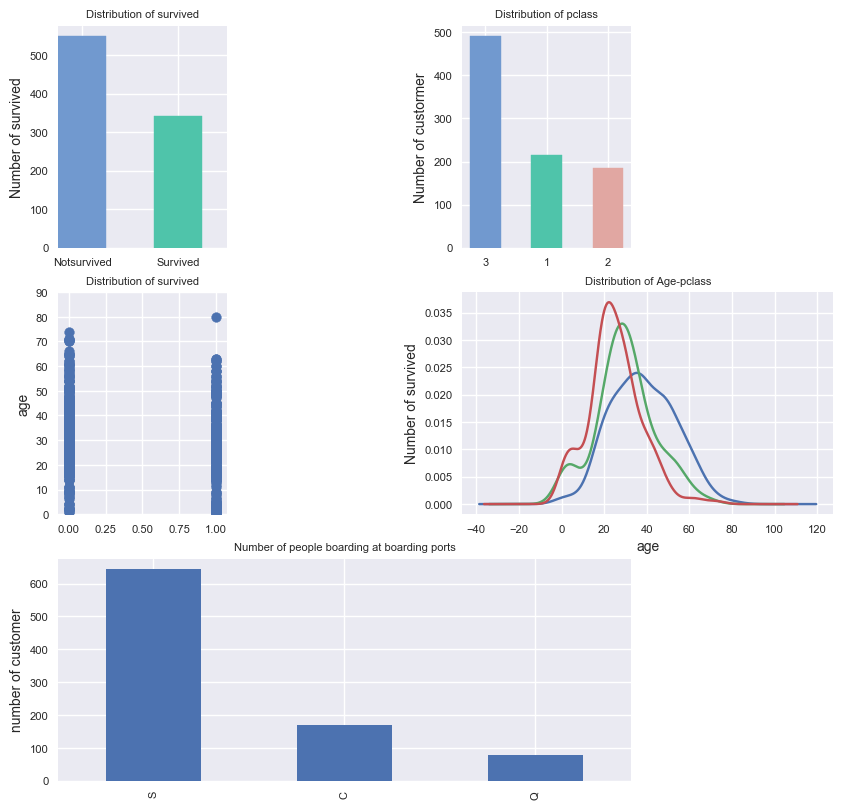

In [143]:
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.major.size'] = 0
mpl.rcParams['ytick.major.size'] = 0

# 创建一个 10 * 10 点（point）的图，并设置分辨率为 80
fig = plt.figure(figsize=(10,10), dpi=100)

# Customer survived distribution
# 在整张图上加入一个子图，131的意思是在一个1行3列的子图中的第一张
ax = plt.subplot2grid((3, 4), (0, 0), colspan=1)
#ax = fig.add_subplot(421)
xticks = np.arange(2)*2
# Series.value_counts返回的是该Series对象中独一无二的元素的个数
survived = dataset.Survived.value_counts()
bar_width = 1
# 画柱状图，横轴是两类标签的位置，纵轴是人数，定义柱的宽度，同时设置柱的边缘为透明
bars = ax.bar(xticks, survived, width=bar_width, edgecolor='none')
# 设置y轴的标题
ax.set_ylabel('Number of survived')
# x轴每个标签的具体位置，设置为每个柱的中央
ax.set_xticks(xticks+bar_width/2-0.5)
# 设置每个标签的名字
ax.set_xticklabels(['Notsurvived', 'Survived'])
# 设置x轴的范围
ax.set_xlim([bar_width/2-1, 3.5-bar_width/2])
# 设置标题
plt.title('Distribution of survived')
# 给每个bar分配指定的颜色
colors = ['#7199cf', '#4fc4aa', '#e1a7a2']
for bar, color in zip(bars, colors):
    bar.set_color(color)


# Customer pclass distribution
#ax = fig.add_subplot(4,2,2)
ax = plt.subplot2grid((3, 4), (0, 2), colspan=1)
xticks = np.arange(3)*2
pclass = dataset.Pclass.value_counts()
bar_width = 1
bars = ax.bar(xticks, pclass, width=bar_width, edgecolor='none')

ax.set_ylabel('Number of custormer')
ax.set_xticks(xticks+bar_width/2-0.5)
ax.set_xticklabels(['3', '1', '2'])
plt.title('Distribution of pclass')
colors = ['#7199cf', '#4fc4aa', '#e1a7a2']
for bar, color in zip(bars, colors):
    bar.set_color(color)
    
# Age-Survived distribution
#ax = fig.add_subplot(412)
ax = plt.subplot2grid((3, 4), (1, 0), colspan=1)
plt.scatter(dataset.Survived, dataset.Age)
ax.set_ylim([0, 90])
plt.title('Distribution of Age-Survived')
ax.set_ylabel('age')
# 设置标题
plt.title('Distribution of survived')
# 给每个bar分配指定的颜色
colors = ['#7199cf', '#4fc4aa', '#e1a7a2']
for bar, color in zip(bars, colors):
    bar.set_color(color)


# Age-pclass distribution
ax = plt.subplot2grid((3, 4), (1, 2), colspan=3)
dataset.Age[dataset.Pclass == 1].plot(kind='kde')
dataset.Age[dataset.Pclass == 2].plot(kind='kde')
dataset.Age[dataset.Pclass == 3].plot(kind='kde')
plt.title('Distribution of Age-pclass')
ax.set_ylabel('Number of survived')
ax.set_xlabel('age')

ax = plt.subplot2grid((3, 4), (2, 0), colspan=3)
dataset.Embarked.value_counts().plot(kind='bar')
plt.title('Number of people boarding at boarding ports')
plt.ylabel('number of customer')

# show
plt.show()

**<font color=red>看图说话</font>**<br>
在图上可以看出来：

被救的人300多点，不到半数；

3等舱乘客灰常多；遇难和获救的人年龄似乎跨度都很广；

3个不同的舱年龄总体趋势似乎也一致，2/3等舱乘客20岁多点的人最多，1等舱40岁左右的最多；

**<font color=red>具体的还得具体统计分析</font>**<br>

### 属性与获救结果的关联统计

**<font color=red>仓位与获救情况分析</font>**<br>

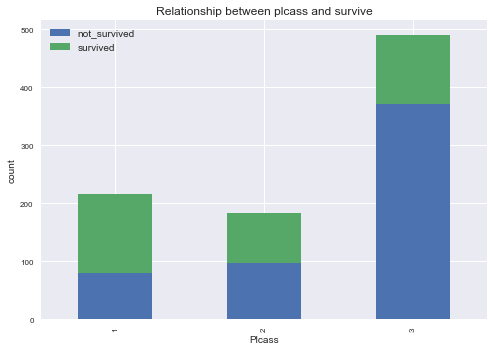

In [144]:
fig2 = plt.figure()
mpl.rcParams['axes.titlesize'] = 12
fig2.set(alpha=0.2)
not_survived = dataset.Pclass[dataset.Survived == 0].value_counts()
survived = dataset.Pclass[dataset.Survived == 1].value_counts()
df = pd.DataFrame({'survived' : survived, 'not_survived' : not_survived})
df.plot(kind='bar', stacked=True)
plt.title('Relationship between plcass and survive')
plt.xlabel('Plcass') 
plt.ylabel('count') 
plt.show()

**<font color=red>可以看到仓位越好，获救的概率越大，头等舱大于2等舱，2等舱大于3等舱</font>**<br>

**<font color=red>分析一下性别与获救的关系</font>**<br>

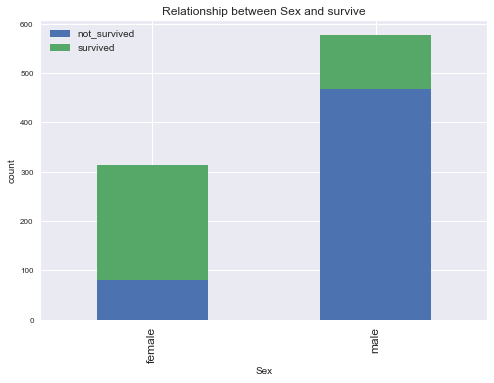

In [145]:
fig3 = plt.figure()
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
fig3.set(alpha=0.2)
not_survived = dataset.Sex[dataset.Survived == 0].value_counts()
survived = dataset.Sex[dataset.Survived == 1].value_counts()
df = pd.DataFrame({'survived' : survived, 'not_survived' : not_survived})
df.plot(kind='bar', stacked=True)
plt.title('Relationship between Sex and survive')
plt.xlabel('Sex') 
plt.ylabel('count') 
plt.show()

**<font color=red>发现女性（female）明显获救的比例比男性获救的比例高。</font>**<br>

**<font color=red>下面综合分析一下，女性Sex，仓位Pclass，与survive三个属性之间的关系</font>**<br>

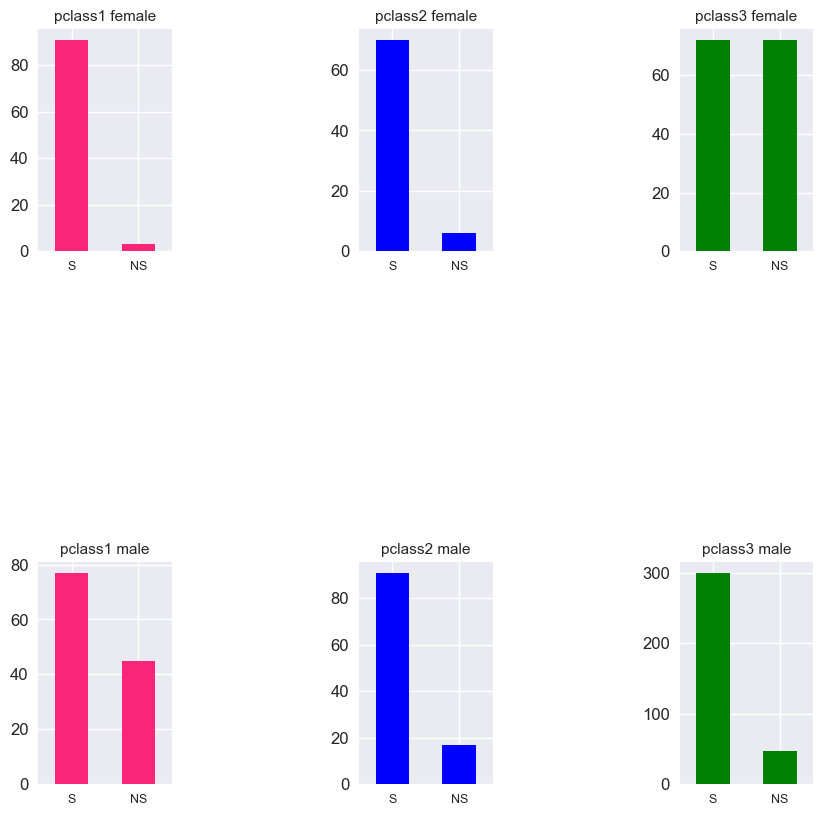

In [146]:
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 11
fig4 = plt.figure(figsize=(10,10), dpi=100)


'''
fig4 = plt.figure()
ax1 = fig4.add_subplot(141)
df1 = dataset.Survived[dataset.Pclass == 1][dataset.Sex == 'female'].value_counts()
df1.plot(kind='bar', label="female highclass", color='#FA2479')
ax1.set_xticklabels(["S", "NS"], rotation=0)
plt.title('pclass1')


'''
def plot_sub(fig, row, col, pclass, sex, title, pcolor='#FA2479'):
    ax = plt.subplot2grid((3, 5), (row, col), colspan=1)   
    df = dataset.Survived[dataset.Pclass == pclass][dataset.Sex == sex].value_counts()
    df.plot(kind='bar', color=pcolor)
    ax.set_xticklabels(["S", "NS"], rotation=0)
    plt.title(title)

plot_sub(fig4, 0, 0, 1, 'female', 'pclass1 female')
plot_sub(fig4, 0, 2, 2, 'female', 'pclass2 female', pcolor='blue')
plot_sub(fig4, 0, 4, 3, 'female', 'pclass3 female', pcolor='green')

plot_sub(fig4, 2, 0, 1, 'male', 'pclass1 male')
plot_sub(fig4, 2, 2, 2, 'male', 'pclass2 male', pcolor='blue')
plot_sub(fig4, 2, 4,3, 'male', 'pclass3 male', pcolor='green')

plt.show()

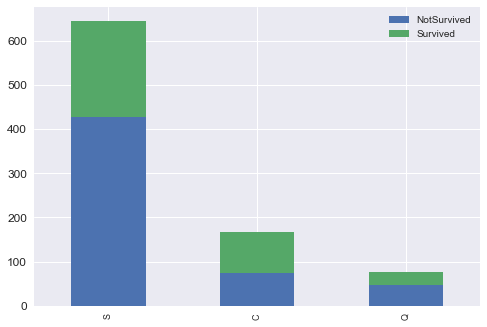

In [147]:
fig5 = plt.figure()
S = dataset.Embarked[dataset.Survived == 1].value_counts()
N = dataset.Embarked[dataset.Survived == 0].value_counts()
df = pd.DataFrame({'Survived' : S, 'NotSurvived' : N})
df.plot(kind='bar', stacked=True)
plt.show()

**<font color=red>貌似C登船口幸存者比例较高</font>**<br>

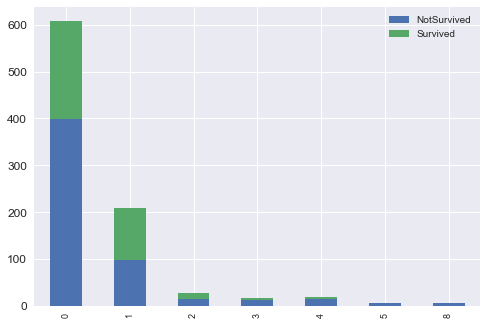

In [148]:
fig5 = plt.figure()
S = dataset.SibSp[dataset.Survived == 1].value_counts()
N = dataset.SibSp[dataset.Survived == 0].value_counts()
df = pd.DataFrame({'Survived' : S, 'NotSurvived' : N})
df.plot(kind='bar', stacked=True)
plt.show()

**<font color=red>亲戚关系没看出来，留作备选特征，Ticket应该是标准的特征，先放弃。看一下Cabin客舱</font>**<br>

In [149]:
#dataset.info()
dataset.head()
dataset.Cabin.value_counts()

G6                 4
C23 C25 C27        4
B96 B98            4
D                  3
F2                 3
C22 C26            3
E101               3
F33                3
C93                2
E8                 2
D17                2
C125               2
D20                2
C83                2
C92                2
B77                2
B35                2
E44                2
E24                2
B5                 2
B49                2
E67                2
D33                2
B58 B60            2
B57 B59 B63 B66    2
C126               2
D35                2
C123               2
E121               2
C78                2
                  ..
E17                1
E10                1
E68                1
A24                1
A6                 1
F G63              1
B37                1
C104               1
C62 C64            1
C95                1
E49                1
D48                1
A10                1
C30                1
C85                1
B102               1
D37          

先这么放着了。下面做数据预处理

## 数据预处理

### 先补全缺失特征

**<font color=red>处理缺失特征的四个基本原则</font>**<br>
> 1.如果缺值的样本占总数比例极高，我们可能就直接舍弃了，作为特征加入的话，可能反倒带入noise，影响最后的结果了

> 2.如果缺值的样本适中，而该属性非连续值特征属性(比如说类目属性)，那就把NaN作为一个新类别，加到类别特征中

> 3.如果缺值的样本适中，而该属性为连续值特征属性，有时候我们会考虑给定一个step(比如这里的age，我们可以考虑每隔2/3岁为一个步长)，然后把它离散化，之后把NaN作为一个type加到属性类目中。

> 4.有些情况下，缺失的值个数并不是特别多，那我们也可以试着根据已有的值，拟合一下数据，补充上。


**<font color=red>可以参考特征处理章节</font>**<br>

In [150]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


**<font color=red>看到Age，Cabin，Embarked这三个特征存在缺省值。</font>**<br>


* Age和Embarked准备用现有数据拟合上；
* Cabin准备将缺失和不缺失的数据分为两类；


### 补全Age先

**<font color=red>用sklearn 补全Age</font>**<br>

In [151]:
from sklearn.ensemble import RandomForestRegressor
import copy

def set_missing_ages(df):
    df_tmp = copy.deepcopy(df)
    data = df_tmp[['Age', 'Pclass', 'Parch', 'SibSp', 'Fare']]
    know_age = data[data.Age.notnull()].as_matrix()
    unknow_age = data[data.Age.isnull()].as_matrix()
    y = know_age[: , 0]
    X = know_age[: , 1:]
    regr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    regr.fit(X, y)
    predictAge = regr.predict(unknow_age[:, 1:])
    df_tmp.loc[(dataset.Age.isnull()), 'Age'] = predictAge
    return df_tmp, regr

def set_Cabin(df):
    df_tmp = copy.deepcopy(df)
    df_tmp.loc[(dataset.Cabin.isnull()), 'Cabin'] = 'NO'
    df_tmp.loc[(dataset.Cabin.notnull()), 'Cabin'] = 'YES'
    return df_tmp

dataset2, regr = set_missing_ages(dataset)
dataset2 = set_Cabin(dataset2)

In [152]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB



**<font color=red>Okay，现在把Age，Cabin两值的缺省处理完了，再看看数据</font>**<br>

In [153]:
dataset2.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NO,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,YES,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NO,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,YES,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NO,S
5,6,0,3,"Moran, Mr. James",male,23.828953,0,0,330877,8.4583,NO,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,YES,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NO,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NO,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,NO,C


### One-Hot Encoding
在实际的机器学习的应用任务中，特征有时候并不总是连续值，有可能是一些分类值，如性别可分为“male”和“female”。在机器学习任务中，对于这样的特征，通常我们需要对其进行特征数字化。

在这个问题中，我们要把Sex、Cabin、Pclass和Embarked这4个特征数字化。

Cabin原本一个属性维度，因为其取值可以是[‘yes’,’no’]，而将其平展开为’Cabin_yes’,’Cabin_no’两个属性。
* 原本Cabin取值为yes的，在此处的”Cabin_yes”下取值为1，在”Cabin_no”下取值为0；
* 原本Cabin取值为no的，在此处的”Cabin_yes”下取值为0，在”Cabin_no”下取值为1；


In [154]:
cabin_dummies = pd.get_dummies(dataset2['Cabin'], prefix='Cabin')
sex_dummies = pd.get_dummies(dataset2['Sex'], prefix='Sex')
pclass_dummies = pd.get_dummies(dataset2['Pclass'], prefix='Pclass')
embarked_dummies = pd.get_dummies(dataset2['Embarked'], prefix='Embarked')
dataset3 = copy.deepcopy(dataset2)
dataset3 = pd.concat([dataset3, cabin_dummies, sex_dummies, pclass_dummies, embarked_dummies], axis=1)
dataset3.drop(['Name','Cabin', 'Sex', 'Pclass', 'Embarked', 'Ticket'], axis=1, inplace=True)

In [155]:
dataset3.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_NO,Cabin_YES,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,1,0,0,1,0,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,0,1,1,0,1,0,0,1,0,0
2,3,1,26.0,0,0,7.9250,1,0,1,0,0,0,1,0,0,1
3,4,1,35.0,1,0,53.1000,0,1,1,0,1,0,0,0,0,1
4,5,0,35.0,0,0,8.0500,1,0,0,1,0,0,1,0,0,1


这回数据处理的有点样了，不过Age和Fare特征还没处理好，Age和Fare两个属性的数值幅度变化很大，这里我们做归一化，把这连个变量scaling(缩放)到[-1,1]之间。

In [156]:
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(dataset3.Age)
dataset3['Age_scaled'] = scaler.fit_transform(dataset3['Age'], age_scale_param)
fare_scale_param = scaler.fit(dataset3['Fare'])
dataset3['Fare_scaled'] = scaler.fit_transform(dataset3['Fare'], fare_scale_param)

/Users/bobkentt/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/bobkentt/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/bobkentt/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1)

In [157]:
dataset3.head(10)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_NO,Cabin_YES,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age_scaled,Fare_scaled
0,1,0,22.000000,1,0,7.2500,1,0,0,1,0,0,1,0,0,1,-0.561364,-0.502445
1,2,1,38.000000,1,0,71.2833,0,1,1,0,1,0,0,1,0,0,0.613182,0.786845
2,3,1,26.000000,0,0,7.9250,1,0,1,0,0,0,1,0,0,1,-0.267727,-0.488854
3,4,1,35.000000,1,0,53.1000,0,1,1,0,1,0,0,0,0,1,0.392955,0.420730
4,5,0,35.000000,0,0,8.0500,1,0,0,1,0,0,1,0,0,1,0.392955,-0.486337
5,6,0,23.828953,0,0,8.4583,1,0,0,1,0,0,1,0,1,0,-0.427102,-0.478116
6,7,0,54.000000,0,0,51.8625,0,1,0,1,1,0,0,0,0,1,1.787729,0.395814
7,8,0,2.000000,3,1,21.0750,1,0,0,1,0,0,1,0,0,1,-2.029547,-0.224083
8,9,1,27.000000,0,2,11.1333,1,0,1,0,0,0,1,0,0,1,-0.194318,-0.424256
9,10,1,14.000000,1,0,30.0708,1,0,1,0,0,1,0,1,0,0,-1.148637,-0.042956


**<font color=red>Okay，特征工程做到这里基本差不多了</font>**<br>

## 建模
### 用sklean的logistics regression做个baseline

把需要的feature字段取出来，转成numpy格式，使用scikit-learn中的LogisticRegression建模。

In [158]:
from sklearn import linear_model

train_df = dataset3.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()
X = train_np[:, 1:]
y = train_np[:, 0]
lr_regr = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)

lr_regr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

### 按照上面的步骤把测试集数据也做特征工程

In [159]:
data_test = pd.read_csv("../input/kaggle_titanic_data/test.csv")
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0
# 接着我们对test_data做和train_data中一致的特征变换
# 首先用同样的RandomForestRegressor模型填上丢失的年龄
tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
null_age = tmp_df[data_test.Age.isnull()].as_matrix()
# 根据特征属性X预测年龄并补上
X = null_age[:, 1:]
predictedAges = regr.predict(X)

data_test.loc[ (data_test.Age.isnull()), 'Age' ] = predictedAges

data_test = set_Cabin(data_test)
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')


df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df_test['Age_scaled'] = scaler.fit_transform(df_test['Age'], age_scale_param)
df_test['Fare_scaled'] = scaler.fit_transform(df_test['Fare'], fare_scale_param)



/Users/bobkentt/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/bobkentt/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/bobkentt/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1)

**<font color=red>运行模型预测测试集数据</font>**<br>

In [160]:
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions = lr_regr.predict(test)
print(type(predictions))
print(predictions)

<class 'numpy.ndarray'>
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.
  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.
  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.  0.  1.  0.  0.  0.
  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.
  1.  0.  0.  0.  1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  1.
  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.
  1.  0.  0.  1.  1.  1.  1

**<font color=red>保存预测结果</font>**<br>

In [161]:
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("../output/Titanic_data/logistic_regression_predictions.csv", index=False)

**<font color=red>在kaggle上make a submission一下baseline结果</font>**<br>

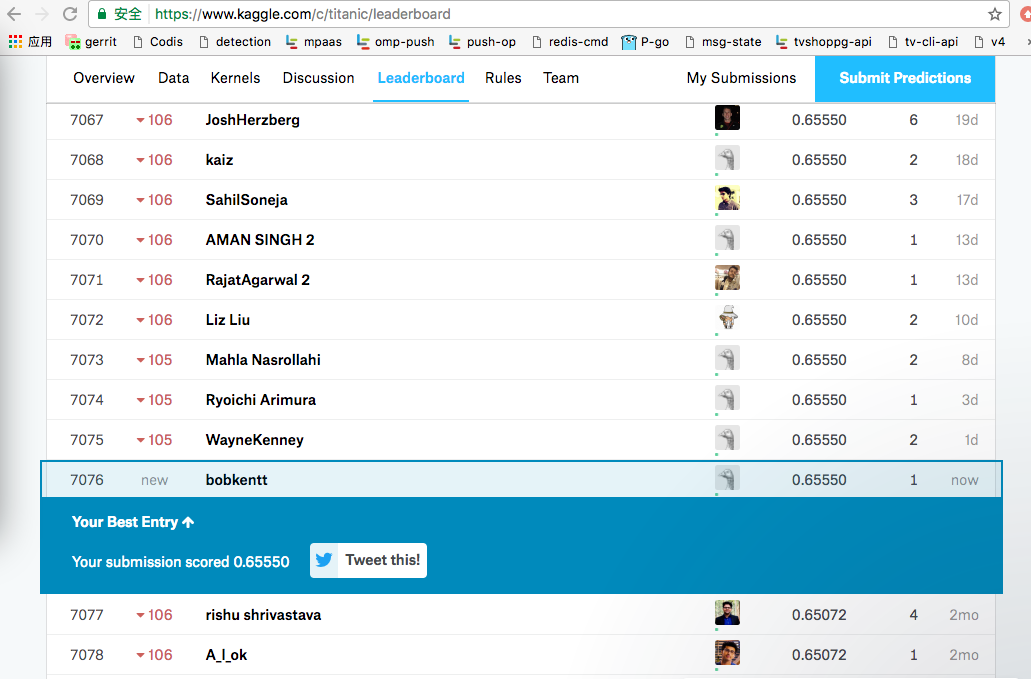

In [162]:
from IPython.display import Image
Image(filename="D805EAA4-5FCA-4CB1-B788-BEF90B34D9F3.png")

在baseline之后，继续挖掘其它属性。
1. Name和Ticket两个属性被舍弃了，因为几乎每一条记录都是一个完全不同的值，我们并没有找到很直接的处理方式；
2. 年龄的拟合本身也未必是一件非常靠谱的事情，而且老人和小孩在救援过程中必然是受照顾的对象，所以年龄属性按区段分属性也许是好的选择

In [163]:
tp = pd.DataFrame({'col': list(train_df.columns[1:]) , 'val': list(lr_regr.coef_.T)})
print(tp)

            col                val
0         SibSp  [-0.344231546512]
1         Parch  [-0.104931262869]
2      Cabin_NO              [0.0]
3     Cabin_YES   [0.902140426111]
4    Sex_female    [1.95657581095]
5      Sex_male  [-0.677421106439]
6      Pclass_1   [0.341151203861]
7      Pclass_2              [0.0]
8      Pclass_3   [-1.19414313214]
9    Embarked_C              [0.0]
10   Embarked_Q              [0.0]
11   Embarked_S  [-0.417258699068]
12   Age_scaled   [-0.52379029922]
13  Fare_scaled  [0.0844324151495]


分析一下：
1. Sex特征：是Sex_female的系数是1.95，Sex_male的系数是-0.677，说明女性获救的几率很高；
2. Cabin特征：有统计记录的获救几率高，这个特征有待继续挖掘；
3. Pclass特征：Pclass_1一等舱的乘客获救几率高，Pclass_3获救几率降低；
4. Embarked特征：显示Embarked_S登船口上的乘客，幸存可能性低，与我们前期观察到的特征不符，可能考虑去掉Embarked特征试试；
5. Age特征：呈现负相关，似乎年龄越小获救率越高，需继续挖掘；
6. Fare特征：呈微弱正相关，票越贵获救几率越高？需继续观察；

## 交叉验证（cross validation）
不能每做一次调整就make a submission，然后根据结果来判定这次调整的好坏；

这么做cross validation：把train.csv分成两部分，一部分用于训练需要的模型，另外一部分数据上看预测算法的效果。

我们用scikit-learn的cross_validation来帮我们完成小数据集上的这个工作。

先简单看看cross validation情况下的打分

**<font color=red>用留出法把训练集数据按照7：3划分，然后训练模型，在结果集上预测。预测结果与正确结果对比，找到bad case。然后肉眼看bad case。</font>**<br>

In [170]:
from sklearn import cross_validation
# 分割数据，按照 训练数据:cv数据 = 7:3的比例
split_train, split_cv = cross_validation.train_test_split(dataset3, test_size=0.3, random_state=0)
train_df2 = split_train.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
# 生成模型
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(train_df2.as_matrix()[:,1:], train_df2.as_matrix()[:,0])
# 对cross validation数据进行预测
cv_df = split_cv.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions = clf.predict(cv_df.as_matrix()[:,1:])
origin_data_train = pd.read_csv("../input/kaggle_titanic_data/train.csv")
bad_cases = origin_data_train.loc[origin_data_train['PassengerId'].isin(split_cv[predictions != cv_df.as_matrix()[:,0]]['PassengerId'].values)]
bad_cases

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.00,0,0,350406,7.8542,NaN,S
49,50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.00,1,0,349237,17.8000,NaN,S
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.00,4,2,3101281,7.9250,NaN,S
85,86,1,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.00,3,0,3101278,15.8500,NaN,S
113,114,0,3,"Jussila, Miss. Katriina",female,20.00,1,0,4136,9.8250,NaN,S
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C
204,205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.00,0,0,A/5 3540,8.0500,NaN,S
240,241,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C


1. Age属性不使用现在的拟合方式，而是根据名称中的『Mr』『Mrs』『Miss』等的平均值进行填充。
2. Age不做成一个连续值属性，而是使用一个步长进行离散化，变成离散的类目feature。
3. Cabin再细化一些，对于有记录的Cabin属性，我们将其分为前面的字母部分(我猜是位置和船层之类的信息) 和 后面的数字部分(应该是房间号，有意思的事情是，如果你仔细看看原始数据，你会发现，这个值大的情况下，似乎获救的可能性高一些)。
4. Pclass和Sex俩太重要了，我们试着用它们去组出一个组合属性来试试，这也是另外一种程度的细化。
5. 单加一个Child字段，Age<=12的，设为1，其余为0(你去看看数据，确实小盆友优先程度很高啊)
6. 如果名字里面有『Mrs』，而Parch>1的，我们猜测她可能是一个母亲，应该获救的概率也会提高，因此可以多加一个Mother字段，此种情况下设为1，其余情况下设为0
7. 登船港口可以考虑先去掉试试(Q和C本来就没权重，S有点诡异)
8. 把堂兄弟/兄妹 和 Parch 还有自己 个数加在一起组一个Family_size字段(考虑到大家族可能对最后的结果有影响)
9. Name是一个我们一直没有触碰的属性，我们可以做一些简单的处理，比如说男性中带某些字眼的(‘Capt’, ‘Don’, ‘Major’, ‘Sir’)可以统一到一个Title，女性也一样。

## Learning curve

### 画Learning curve